# 原图-预测

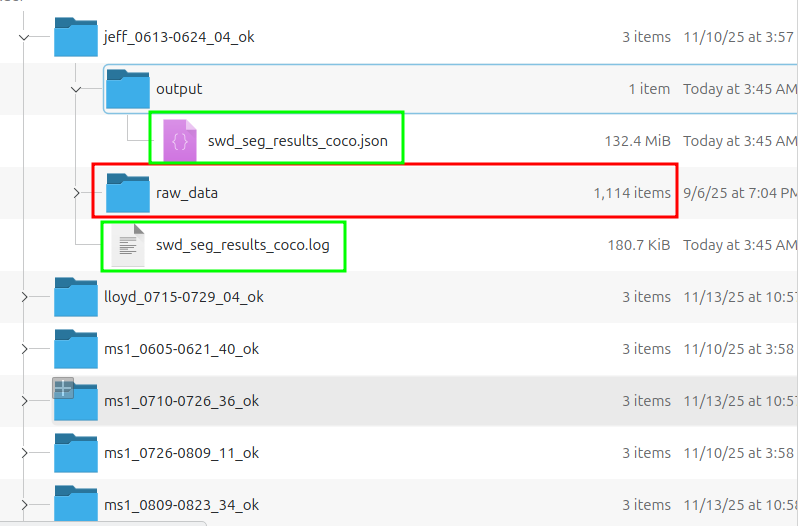

```json
{
    "info": {
        "description": "SWD COCO format instance segmentation",
        "version": "1.0",
        "year": 2025,
        "contributor": "Tianqi Yao",
    },
    "licenses": [
      {
        "id": 1, 
        "name": "CC BY-NC 4.0",
        "url": "https://creativecommons.org/licenses/by-nc/4.0/"
      }
    ],
    "images": [
        {
            "id": 100,
            "file_name": "0730_1834_760.jpg",
            "width": 640,
            "height": 480,
            "license": 1,
            "date_captured": "2024-07-30T18:34:00-05:00",  // ISO 8601 format, US central time
            "focal_length_parameter": 760
        }
    ],
    "annotations": [
        {
            "id": 1,
            "image_id": 100,
            "category_id": 1,
            "object_id": "", // UUID string
            "score": 0.92,
            "segmentation": [[x1, y1, x2, y2, ...]],  // pixel coordinates
            "area": 1032.0,
            "bbox": [x, y, width, height],  //  pixel coordinates
            "iscrowd": 0,
        }
    ],
    "categories": [
        {
            "id": 1,
            "name": "swd",
            "supercategory": "object",
        }
    ]
}
```

In [1]:
# ====================核心模块=====================
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Iterable, List, Tuple

import logging  # <<< 新增
import cv2
import numpy as np
import orjson
import torch
import yaml
from ultralytics import YOLO
from uuid import uuid4
from datetime import datetime
from zoneinfo import ZoneInfo

# === 强制使用美国中部时间 CST/CDT ===
CENTRAL_TZ = ZoneInfo('US/Central')

def central_time(*args):
    return datetime.now(CENTRAL_TZ).timetuple()


# 全局 logger（后面通过 basicConfig 配置）
LOGGER = logging.getLogger(__name__)  # <<< 新增


# ============================================================
# 常量：只放跟当前需求强相关的
# ============================================================

IMAGE_EXTENSIONS: Tuple[str, ...] = (
    ".jpg",
    ".jpeg",
    ".png",
    ".bmp",
    ".tif",
    ".tiff",
    ".webp",
)

MIN_OVERLAP_RATIO: float = 0.0
MAX_OVERLAP_RATIO: float = 0.99
MIN_TILE_STEP: int = 1
MIN_POLYGON_POINTS: int = 3

MAX_TILES_PER_BATCH: int = 64

COCO_IS_CROWD: int = 0


# ============================================================
# 配置相关 dataclass
# ============================================================

@dataclass(frozen=True)
class ProcessingConfig:
    """图像切片配置（来自 YAML）"""
    tile_height: int
    tile_width: int
    overlap_ratio: float


@dataclass(frozen=True)
class YoloConfig:
    """YOLO 推理配置（来自 YAML）"""
    model_path: str
    image_size: int
    confidence_threshold: float
    iou_threshold: float
    device: int
    batch_size: int
    retina_masks: bool
    workers: int
    verbose: bool
    save_results: bool


@dataclass(frozen=True)
class PipelineInputConfig:
    """输入目录配置"""
    root_directory: str
    search_depth: int
    # 若之后想改 raw_data 名字，可以加字段；现在写死即可


@dataclass(frozen=True)
class PipelineOutputConfig:
    """输出目录配置"""
    directory_name: str
    file_name: str


@dataclass(frozen=True)
class PipelineConfig:
    """Pipeline I/O 配置"""
    input: PipelineInputConfig
    output: PipelineOutputConfig


@dataclass(frozen=True)
class CategoryConfig:
    """类别配置，对应 YAML 中的 categories"""
    id: int
    name: str
    supercategory: str


@dataclass(frozen=True)
class LoggingConfig:  # <<< 新增：日志配置
    """日志配置（来自 YAML）"""
    log_file_name: str           # 每个 *_try 目录下的日志文件名，如 "pipeline.log"
    level: str = "INFO"      # 日志级别：DEBUG / INFO / WARNING / ERROR
    force: bool = False      # Notebook 下建议 True，方便重复运行时重置 handler


@dataclass(frozen=True)
class AppConfig:
    """顶层配置，完整对应 config.yaml"""
    processing: ProcessingConfig
    yolo: YoloConfig
    pipeline: PipelineConfig
    categories: List[CategoryConfig]
    logging: LoggingConfig     # <<< 新增字段

    @staticmethod
    def load_from_yaml(config_path: Path) -> AppConfig:
        with config_path.open("r", encoding="utf-8") as file:
            raw: Dict[str, Any] = yaml.safe_load(file)

        processing = ProcessingConfig(**raw["processing"])
        yolo = YoloConfig(**raw["yolo"])

        pipeline_input = PipelineInputConfig(**raw["pipeline"]["input"])
        pipeline_output = PipelineOutputConfig(**raw["pipeline"]["output"])
        pipeline = PipelineConfig(input=pipeline_input, output=pipeline_output)

        categories = [
            CategoryConfig(**category_dict) for category_dict in raw["categories"]
        ]

        logging_cfg = LoggingConfig(**raw["pipeline"]["logging"])  # <<< 新增：读取 logging 配置

        return AppConfig(
            processing=processing,
            yolo=yolo,
            pipeline=pipeline,
            categories=categories,
            logging=logging_cfg,  # <<< 新增
        )


# ============================================================
# 模型与检测结果的数据结构
# ============================================================

@dataclass
class SingleDetection:
    """单个目标检测结果（原图坐标系）"""
    image_stem: str
    label_name: str
    score: float
    polygon_points: List[List[float]]
    object_id: str


@dataclass(frozen=True)
class CocoCategory:
    category_id: int
    name: str
    supercategory: str


@dataclass
class CocoImage:
    image_id: int
    file_name: str
    width: int
    height: int
    timestamp: str   # 用字符串保存，避免 JSON 序列化问题
    focal_length_parameter: int


@dataclass
class CocoAnnotation:
    annotation_id: int
    image_id: int
    category_id: int
    segmentation: List[float]
    area: float
    bbox: List[float]
    iscrowd: int
    score: float
    object_id: str


@dataclass
class CocoDataset:
    images: List[CocoImage]
    annotations: List[CocoAnnotation]
    categories: List[CocoCategory]

    def to_dict(self) -> Dict[str, Any]:
        # COCO 格式的 licenses 信息
        licenses = [
            {
                "id": 1, 
                "name": "CC BY-NC 4.0",
                "url": "https://creativecommons.org/licenses/by-nc/4.0/"
            }
        ]
        # COCO 格式的 info 信息
        info = {
            "description": "SWD COCO format instance segmentation",
            "version": "1.0", 
            "year": 2025,
            "contributor": "Tianqi Yao",
        }
        
        # 处理 images 列表
        images_list = []
        for image in self.images:
            # 将时间戳转换为 ISO 8601 格式（美国中部时间）
            try:
                # 假设时间戳格式为 "MMDD_HHMM"
                if image.timestamp and len(image.timestamp) == 9:  # "MMDD_HHMM"
                    month = int(image.timestamp[:2])
                    day = int(image.timestamp[2:4])
                    hour = int(image.timestamp[5:7])
                    minute = int(image.timestamp[7:9])
                    # 假设年份为当前年（或从配置中获取）
                    year = 2024  # 可以根据需要调整
                    dt = datetime(year, month, day, hour, minute, tzinfo=CENTRAL_TZ)
                    date_captured = dt.isoformat()
                else:
                    date_captured = ""
            except (ValueError, IndexError):
                date_captured = ""
                
            images_list.append({
                "id": image.image_id,
                "file_name": image.file_name,
                "width": image.width,
                "height": image.height,
                "license": 1,
                "date_captured": date_captured,
                "focal_length_parameter": image.focal_length_parameter,
            })
        
        # 处理 annotations 列表
        annotations_list = []
        for annotation in self.annotations:
            annotations_list.append({
                "id": annotation.annotation_id,
                "image_id": annotation.image_id,
                "category_id": annotation.category_id,
                "object_id": annotation.object_id,
                "score": annotation.score,
                "segmentation": [annotation.segmentation],  # 注意这里包装成列表
                "area": annotation.area,
                "bbox": annotation.bbox,
                "iscrowd": annotation.iscrowd,
            })
        
        # 处理 categories 列表
        categories_list = []
        for category in self.categories:
            categories_list.append({
                "id": category.category_id,
                "name": category.name,
                "supercategory": category.supercategory,
            })
        
        return {
            "info": info,
            "licenses": licenses,
            "images": images_list,
            "annotations": annotations_list,
            "categories": categories_list,
        }


# ============================================================
# 日志配置工具函数
# ============================================================

def configure_logging_for_directory(
    parent_directory: Path,
    logging_config: LoggingConfig,
) -> None:
    """
    为当前 parent_directory 配置日志：
    - 日志文件路径：parent_directory / logging_config.file_name
    - 同时输出到控制台
    - 使用 logging_config.force 控制是否强制重置（适合 Notebook）
    """
    log_file_path: Path = parent_directory / logging_config.log_file_name
    log_file_path.parent.mkdir(parents=True, exist_ok=True)

    level_name: str = logging_config.level.upper()
    log_level: int = getattr(logging, level_name, logging.INFO)

    logging.basicConfig(
        level=log_level,
        format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        handlers=[
            logging.FileHandler(log_file_path, encoding="utf-8", mode="w"),
            logging.StreamHandler(),
        ],
        force=logging_config.force,  # <<< Notebook 下建议设为 True
    )

    logging.Formatter.converter = central_time  # <<< 使用美国中部时间

    LOGGER.info("Logging configured. Log file: %s", log_file_path)


# ============================================================
# 工具函数：目录与图片收集
# ============================================================

def find_parent_directories_with_raw_data(
    root_directory: Path,
    search_depth: int,
    raw_data_directory_name: str = "raw_data",
) -> List[Path]:
    """
    在 root_directory 下（限制搜索层数）查找包含 raw_data 子目录的父目录。

    示例：
        root_directory = /.../00_test
        返回：[.../00_test/00_try, .../00_test/01_try, ...]
    """
    directories_to_visit: List[Tuple[Path, int]] = [(root_directory, 0)]
    parent_directories: List[Path] = []

    while directories_to_visit:
        current_directory, current_depth = directories_to_visit.pop()

        raw_data_directory: Path = current_directory / raw_data_directory_name
        if raw_data_directory.exists() and raw_data_directory.is_dir():
            parent_directories.append(current_directory)

        if current_depth >= search_depth:
            continue

        for child in current_directory.iterdir():
            if child.is_dir():
                directories_to_visit.append((child, current_depth + 1))

    return parent_directories


def directory_contains_images(raw_data_directory: Path) -> bool:
    for extension in IMAGE_EXTENSIONS:
        if any(raw_data_directory.glob(f"*{extension}")):
            return True
    return False


def collect_image_paths_from_raw_data(raw_data_directory: Path) -> List[Path]:
    image_paths: List[Path] = []
    for extension in IMAGE_EXTENSIONS:
        image_paths.extend(raw_data_directory.glob(f"*{extension}"))
    image_paths.sort()
    return image_paths


# ============================================================
# 图像切片与 YOLO 推理
# ============================================================

def generate_tile_windows(
    image_height: int,
    image_width: int,
    processing_config: ProcessingConfig,
) -> List[Tuple[int, int, int, int]]:
    """
    生成所有切片窗口 (x_start, y_start, x_end, y_end)。
    """
    overlap_ratio: float = max(
        MIN_OVERLAP_RATIO,
        min(MAX_OVERLAP_RATIO, processing_config.overlap_ratio),
    )

    step_height: int = max(
        MIN_TILE_STEP,
        int(round(processing_config.tile_height * (1.0 - overlap_ratio))),
    )
    step_width: int = max(
        MIN_TILE_STEP,
        int(round(processing_config.tile_width * (1.0 - overlap_ratio))),
    )

    y_start_values: List[int] = list(
        range(
            0,
            max(1, image_height - processing_config.tile_height + 1),
            step_height,
        )
    )
    x_start_values: List[int] = list(
        range(
            0,
            max(1, image_width - processing_config.tile_width + 1),
            step_width,
        )
    )

    # 确保覆盖右下边缘
    last_y_start: int = max(0, image_height - processing_config.tile_height)
    last_x_start: int = max(0, image_width - processing_config.tile_width)
    if y_start_values[-1] != last_y_start:
        y_start_values.append(last_y_start)
    if x_start_values[-1] != last_x_start:
        x_start_values.append(last_x_start)

    windows: List[Tuple[int, int, int, int]] = []
    for y_start in y_start_values:
        y_end: int = min(y_start + processing_config.tile_height, image_height)
        for x_start in x_start_values:
            x_end: int = min(x_start + processing_config.tile_width, image_width)
            windows.append((x_start, y_start, x_end, y_end))

    return windows


def run_yolo_on_tile_batch(
    model: YOLO,
    tiles: List[np.ndarray],
    offsets: List[Tuple[int, int]],
    yolo_config: YoloConfig,
    image_stem: str,
) -> List[SingleDetection]:
    if not tiles:
        return []

    results = model.predict(
        tiles,
        imgsz=yolo_config.image_size,
        conf=yolo_config.confidence_threshold,
        iou=yolo_config.iou_threshold,
        device=str(yolo_config.device),
        batch=yolo_config.batch_size,
        workers=yolo_config.workers,
        verbose=yolo_config.verbose,
        save=yolo_config.save_results,
        retina_masks=yolo_config.retina_masks,
    )

    detections: List[SingleDetection] = []

    for tile_index, result in enumerate(results):
        offset_x, offset_y = offsets[tile_index]

        try:
            json_text: str = result.to_json()
            records: List[Dict[str, Any]] = orjson.loads(json_text)
        except Exception:
            continue

        for record in records:
            # 1) 先尝试 segmentation（适用于 seg 模型）
            segments: Dict[str, List[float]] | None = record.get("segments")
            x_values: List[float] = []
            y_values: List[float] = []

            if segments:
                x_values = segments.get("x", []) or []
                y_values = segments.get("y", []) or []

            polygon_points: List[List[float]] = []

            if x_values and y_values:
                # seg 模型：按多边形点构建
                for local_x, local_y in zip(x_values, y_values):
                    global_x: float = float(local_x + offset_x)
                    global_y: float = float(local_y + offset_y)
                    polygon_points.append([global_x, global_y])
            else:
                # 2) 没有 segments → 退回到 bbox（适用于纯 bbox 模型）
                box: Dict[str, Any] = record.get("box", {}) or {}

                # 兼容两种格式：box = {"x1":..., "y1":..., "x2":..., "y2":...}
                # 或者顶层直接有 x1/y1/x2/y2
                x1 = box.get("x1", record.get("x1"))
                y1 = box.get("y1", record.get("y1"))
                x2 = box.get("x2", record.get("x2"))
                y2 = box.get("y2", record.get("y2"))

                if None in (x1, y1, x2, y2):
                    # 既没有 seg 又没有 bbox，跳过这个 detection
                    continue

                x1g = float(x1 + offset_x)
                y1g = float(y1 + offset_y)
                x2g = float(x2 + offset_x)
                y2g = float(y2 + offset_y)

                # 用 bbox 构建一个矩形多边形（顺时针四个角）
                polygon_points = [
                    [x1g, y1g],
                    [x2g, y1g],
                    [x2g, y2g],
                    [x1g, y2g],
                ]

            if len(polygon_points) < MIN_POLYGON_POINTS:
                continue

            label_name: str = str(record.get("name", ""))
            score: float = float(record.get("confidence", 0.0))

            detections.append(
                SingleDetection(
                    image_stem=image_stem,
                    label_name=label_name,
                    score=score,
                    polygon_points=polygon_points,
                    object_id=str(uuid4()),
                )
            )

        del result

    torch.cuda.empty_cache()
    return detections



def run_tiled_inference_on_image(
    image_path: Path,
    model: YOLO,
    processing_config: ProcessingConfig,
    yolo_config: YoloConfig,
) -> List[SingleDetection]:
    raw_buffer: np.ndarray = np.fromfile(str(image_path), dtype=np.uint8)
    if raw_buffer.size == 0:
        LOGGER.warning("Empty file buffer for image: %s", image_path)  # <<< 用 logger
        return []

    decoded_image: np.ndarray = cv2.imdecode(raw_buffer, cv2.IMREAD_COLOR)
    if decoded_image is None:
        LOGGER.warning("Failed to decode image: %s", image_path)  # <<<
        return []

    image_height, image_width = decoded_image.shape[:2]
    windows: List[Tuple[int, int, int, int]] = generate_tile_windows(
        image_height=image_height,
        image_width=image_width,
        processing_config=processing_config,
    )

    all_detections: List[SingleDetection] = []
    current_tiles: List[np.ndarray] = []
    current_offsets: List[Tuple[int, int]] = []

    for x_start, y_start, x_end, y_end in windows:
        tile_image: np.ndarray = decoded_image[y_start:y_end, x_start:x_end]
        current_tiles.append(tile_image)
        current_offsets.append((x_start, y_start))

        if len(current_tiles) >= MAX_TILES_PER_BATCH:
            batch_detections = run_yolo_on_tile_batch(
                model=model,
                tiles=current_tiles,
                offsets=current_offsets,
                yolo_config=yolo_config,
                image_stem=image_path.stem,
            )
            all_detections.extend(batch_detections)
            current_tiles = []
            current_offsets = []

    if current_tiles:
        remaining_detections = run_yolo_on_tile_batch(
            model=model,
            tiles=current_tiles,
            offsets=current_offsets,
            yolo_config=yolo_config,
            image_stem=image_path.stem,
        )
        all_detections.extend(remaining_detections)

    return all_detections


def run_tiled_inference_for_directory(
    raw_data_directory: Path,
    model: YOLO,
    processing_config: ProcessingConfig,
    yolo_config: YoloConfig,
) -> Dict[str, List[SingleDetection]]:
    image_paths: List[Path] = collect_image_paths_from_raw_data(raw_data_directory)
    detections_by_image_stem: Dict[str, List[SingleDetection]] = {}

    total_images: int = len(image_paths)
    if total_images == 0:
        LOGGER.info("No images found in directory: %s", raw_data_directory)  # <<<
        return detections_by_image_stem

    for index, image_path in enumerate(image_paths, start=1):
        LOGGER.info("[%d/%d] Tiled inference on: %s", index, total_images, image_path)  # <<<
        detections: List[SingleDetection] = run_tiled_inference_on_image(
            image_path=image_path,
            model=model,
            processing_config=processing_config,
            yolo_config=yolo_config,
        )
        if detections:
            detections_by_image_stem[image_path.stem] = detections

    return detections_by_image_stem


# ============================================================
# COCO 构建与保存
# ============================================================

def parse_timestamp_from_filename(file_name: str) -> str:
    """
    按你之前的约定：
    0613_0602_580.jpg -> "0613_0602" -> 转成 "0613_0602" 格式。
    注意：这里返回原始字符串，在构建COCO时再转换为ISO格式
    """
    parts = file_name.split("_")
    if len(parts) < 2:
        return ""
    return f"{parts[0]}_{parts[1]}"  # "0613_0602"


def parse_focal_length_from_filename(file_name: str) -> int:
    """
    0613_0602_580.jpg -> 580
    """
    name_without_ext = file_name.split(".")[0]
    parts = name_without_ext.split("_")
    try:
        return int(parts[-1])
    except (ValueError, IndexError):
        return 0


def read_image_size(image_path: Path) -> Tuple[int, int]:
    raw_buffer: np.ndarray = np.fromfile(str(image_path), dtype=np.uint8)
    decoded_image: np.ndarray = cv2.imdecode(raw_buffer, cv2.IMREAD_COLOR)
    if decoded_image is None:
        return 0, 0
    height, width = decoded_image.shape[:2]
    return width, height


def polygon_to_bbox(points: Iterable[Iterable[float]]) -> List[float]:
    x_values, y_values = zip(*points)
    x_min = float(min(x_values))
    y_min = float(min(y_values))
    x_max = float(max(x_values))
    y_max = float(max(y_values))
    width = max(0.0, x_max - x_min)
    height = max(0.0, y_max - y_min)
    return [x_min, y_min, width, height]


def bbox_area(bbox: List[float]) -> float:
    _, _, width, height = bbox
    return max(0.0, width) * max(0.0, height)


def build_category_registry(categories_config: List[CategoryConfig]) -> Dict[str, CocoCategory]:
    registry: Dict[str, CocoCategory] = {}
    for category in categories_config:
        registry[category.name] = CocoCategory(
            category_id=category.id,
            name=category.name,
            supercategory=category.supercategory,
        )
    return registry


def build_coco_dataset_for_directory(
    raw_data_directory: Path,
    detections_by_image_stem: Dict[str, List[SingleDetection]],
    categories_config: List[CategoryConfig],
) -> CocoDataset:
    image_paths: List[Path] = collect_image_paths_from_raw_data(raw_data_directory)
    category_registry: Dict[str, CocoCategory] = build_category_registry(categories_config)

    images: List[CocoImage] = []
    annotations: List[CocoAnnotation] = []
    categories: List[CocoCategory] = list(category_registry.values())

    next_image_id: int = 1
    next_annotation_id: int = 1

    for image_path in image_paths:
        image_stem: str = image_path.stem
        detections: List[SingleDetection] = detections_by_image_stem.get(image_stem, [])
        if not detections:
            continue

        width, height = read_image_size(image_path)
        timestamp_str: str = parse_timestamp_from_filename(image_path.name)
        focal_length_parameter: int = parse_focal_length_from_filename(image_path.name)

        coco_image = CocoImage(
            image_id=next_image_id,
            file_name=image_path.name,
            width=width,
            height=height,
            timestamp=timestamp_str,
            focal_length_parameter=focal_length_parameter,
        )
        images.append(coco_image)
        image_id: int = next_image_id
        next_image_id += 1

        for detection in detections:
            category: CocoCategory | None = category_registry.get(detection.label_name)
            if category is None:
                continue

            bbox = polygon_to_bbox(detection.polygon_points)
            area = bbox_area(bbox)
            segmentation_flat: List[float] = [
                coordinate
                for point in detection.polygon_points
                for coordinate in point
            ]

            coco_annotation = CocoAnnotation(
                annotation_id=next_annotation_id,
                image_id=image_id,
                category_id=category.category_id,
                segmentation=segmentation_flat,
                area=area,
                bbox=bbox,
                iscrowd=COCO_IS_CROWD,
                score=detection.score,
                object_id=detection.object_id,
            )
            annotations.append(coco_annotation)
            next_annotation_id += 1

    return CocoDataset(images=images, annotations=annotations, categories=categories)


def save_coco_dataset(coco_dataset: CocoDataset, output_path: Path) -> None:
    output_path.parent.mkdir(parents=True, exist_ok=True)
    payload: Dict[str, Any] = coco_dataset.to_dict()
    output_path.write_bytes(orjson.dumps(payload, option=orjson.OPT_INDENT_2))
    LOGGER.info("COCO annotations saved to: %s", output_path)  # <<< 改成日志


# ============================================================
# 顶层流程：自动遍历所有 *_try 目录并分别输出 COCO
# ============================================================

def run_pipeline(config_path: Path) -> None:
    app_config: AppConfig = AppConfig.load_from_yaml(config_path)

    processing_config: ProcessingConfig = app_config.processing
    yolo_config: YoloConfig = app_config.yolo
    pipeline_config: PipelineConfig = app_config.pipeline
    logging_config: LoggingConfig = app_config.logging  # <<< 读取 logging 配置

    root_directory: Path = Path(pipeline_config.input.root_directory)
    search_depth: int = pipeline_config.input.search_depth

    # 这里仍然 print 一下基础信息，方便 Notebook 立刻看到
    print(f"Root directory: {root_directory}")
    print(f"Search depth: {search_depth}")

    parent_directories: List[Path] = find_parent_directories_with_raw_data(
        root_directory=root_directory,
        search_depth=search_depth,
        raw_data_directory_name="raw_data",
    )
    if not parent_directories:
        print("No parent directories containing 'raw_data' were found.")
        return

    print("Found the following parent directories with 'raw_data':")
    for directory in parent_directories:
        print(f"  - {directory}")

    # YOLO 模型只加载一次
    model = YOLO(yolo_config.model_path)

    for parent_directory in parent_directories:
        # 每个 *_try 目录单独配置日志到对应 log 文件（和 raw_data 同级）
        configure_logging_for_directory(
            parent_directory=parent_directory,
            logging_config=logging_config,
        )

        raw_data_directory: Path = parent_directory / "raw_data"
        if not directory_contains_images(raw_data_directory):
            LOGGER.info("Skip %s, no images found.", raw_data_directory)  # <<<
            continue

        LOGGER.info("=== Processing directory: %s ===", parent_directory)

        detections_by_image_stem: Dict[str, List[SingleDetection]] = run_tiled_inference_for_directory(
            raw_data_directory=raw_data_directory,
            model=model,
            processing_config=processing_config,
            yolo_config=yolo_config,
        )

        if not detections_by_image_stem:
            LOGGER.info("No detections found in %s, skip COCO building.", raw_data_directory)  # <<<
            continue

        coco_dataset: CocoDataset = build_coco_dataset_for_directory(
            raw_data_directory=raw_data_directory,
            detections_by_image_stem=detections_by_image_stem,
            categories_config=app_config.categories,
        )

        output_directory_name: str = pipeline_config.output.directory_name
        output_file_name: str = pipeline_config.output.file_name

        output_directory: Path = parent_directory / output_directory_name
        output_path: Path = output_directory / output_file_name

        save_coco_dataset(coco_dataset=coco_dataset, output_path=output_path)

In [2]:
# ============================================================
# 入口
# ============================================================

if __name__ == "__main__":
    run_pipeline(config_path=Path("config/01_config.yaml"))

2025-12-10 22:58:58 [INFO] __main__: Logging configured. Log file: /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_0809-0823_34_ok_v22/output/01_swd_seg_results_coco.log
2025-12-10 22:58:58 [INFO] __main__: === Processing directory: /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_0809-0823_34_ok_v22 ===
2025-12-10 22:58:58 [INFO] __main__: [1/1743] Tiled inference on: /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_0809-0823_34_ok_v22/raw_data/0803_2243_760.jpg


Root directory: /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1
Search depth: 1
Found the following parent directories with 'raw_data':
  - /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_0809-0823_34_ok_v22
  - /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/sw1_0605-0613_07_ok_v22
  - /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_0710-0726_36_ok_v22
  - /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms2_0726-0809_13_ok_v22


2025-12-10 22:59:00 [INFO] __main__: [2/1743] Tiled inference on: /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_0809-0823_34_ok_v22/raw_data/0803_2244_800.jpg
2025-12-10 22:59:00 [INFO] __main__: [3/1743] Tiled inference on: /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_0809-0823_34_ok_v22/raw_data/0803_2246_840.jpg
2025-12-10 22:59:00 [INFO] __main__: [4/1743] Tiled inference on: /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_0809-0823_34_ok_v22/raw_data/0803_2247_880.jpg
2025-12-10 22:59:01 [INFO] __main__: [5/1743] Tiled inference on: /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_0809-0823_34_ok_v22/raw_data/0803_2313_760.jpg
2025-12-10 22:59:01 [INFO] __main__: [6/1743] Tiled inference on: /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_0809-0823_34_ok_v22/raw_data/0803_2314_800.jpg
2025-12-10 22:59:02 [INFO] __main__: [7/1743] Tiled inference on: /workspace/_ty/01_data/01_16mp_2024_pipeline_data_obb_v1/ms1_080